In [170]:
import os
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join("..")))
from src.data_loader import get_cleaned_data
import src.feature_engineering
importlib.reload(src.feature_engineering)
from src.feature_engineering import feature_engineering
sns.set_theme(style="whitegrid")

In [171]:
# clean_data_path = "../data/cleaned/cleaned_data.npz"
# data = np.load(clean_data_path, allow_pickle=True)
# X = data["X"] # data
# y = data["y"] # target values
# features = data["features"].tolist() # features
# time = data["time"] # time index

In [172]:
df = get_cleaned_data()
X, y, features, time = feature_engineering(df)

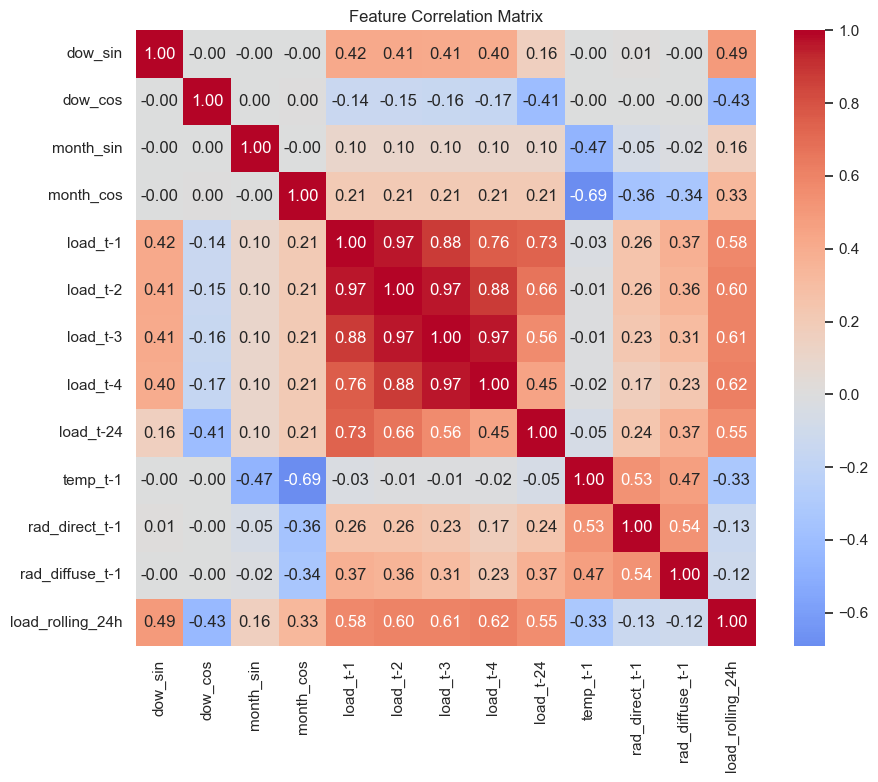

In [173]:

clean_df = pd.DataFrame(X, columns=features)
corr_matrix = clean_df[[name for name in clean_df.columns if "hour" not in name]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

In [174]:
print("Data head:\n", X[:5, :])
print("Target head:\n", y[:5])
print("Features:\n", features)
print("Time Index Head:\n", time[:5])

Data head:
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.33883739e-01
  -9.00968868e-01  5.00000000e-01  8.66025404e-01  5.04180000e+04
   4.56790000e+04  4.23820000e+04  4.03910000e+04  4.11330000e+04
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.67760000e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.33883739e-

In [ ]:
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

def MAPE(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / y_true * 100)

## Linear Regression

In [176]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [177]:
# Cross-validation

tscv = TimeSeriesSplit(n_splits=5)
mae_scores, rmse_scores, mape_scores = [], [], []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = MAE(y_test, y_pred)
    rmse = RMSE(y_test, y_pred)
    mape = MAPE(y_test, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

print(f"Avg MAE: {np.mean(mae_scores):.2f} MW")
print(f"Avg RMSE: {np.mean(rmse_scores):.2f} MW")
print(f"Avg MAPE: {np.mean(mape_scores):.2f} %")

Avg MAE: 755.04 MW
Avg RMSE: 1054.68 MW
Avg MAPE: 1.39 %


In [178]:
split_idx = int(0.8 * X.shape[0])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [179]:
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae = MAE(y_test, y_pred)
rmse = RMSE(y_test, y_pred)
mape = MAPE(y_test, y_pred)

print(f"Linear Regression MAE:  {mae:.2f} MW")
print(f"Linear Regression RMSE: {rmse:.2f} MW")
print(f"Linear Regression MAPE: {mape:.2f} %")

Linear Regression MAE:  754.71 MW
Linear Regression RMSE: 1043.61 MW
Linear Regression MAPE: 1.40 %


In [180]:
coeff_df = pd.DataFrame({"Feature": features, "Coefficient": lr.coef_})
print(coeff_df.sort_values(by="Coefficient", key=abs, ascending=False))

             Feature  Coefficient
3             hour_4  3964.190825
4             hour_5  3705.884672
5             hour_6  3008.490603
7             hour_8  2605.917773
8             hour_9  2589.623684
15           hour_16  2368.974556
6             hour_7  2163.919685
14           hour_15  2153.485836
2             hour_3  2102.755541
9            hour_10  1595.109486
12           hour_13  1473.392886
10           hour_11  1472.202322
13           hour_14  1434.140157
11           hour_12  1400.874493
21           hour_22 -1237.431046
1             hour_2  1173.290520
20           hour_21 -1171.655330
16           hour_17  1096.107650
18           hour_19  -710.273255
0             hour_1   703.399073
19           hour_20  -475.104944
23           dow_sin   268.538175
22           hour_23  -255.495381
26         month_cos  -158.762414
17           hour_18  -116.284680
25         month_sin     5.050396
34   rad_diffuse_t-1    -3.446520
32          temp_t-1    -2.446389
24           d

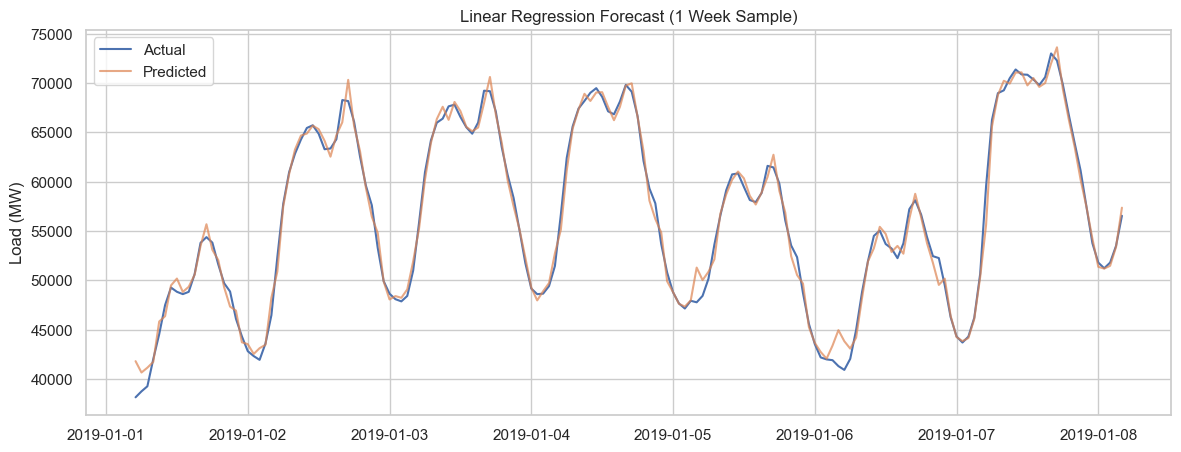

In [181]:
# Plot actual load versus predicted load for 1 week

plt.figure(figsize=(14, 5))
plt.plot(time[split_idx:split_idx+168], y_test[:168], label="Actual")
plt.plot(time[split_idx:split_idx+168], y_pred[:168], label="Predicted", alpha=0.7)
plt.title("Linear Regression Forecast (1 Week Sample)")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

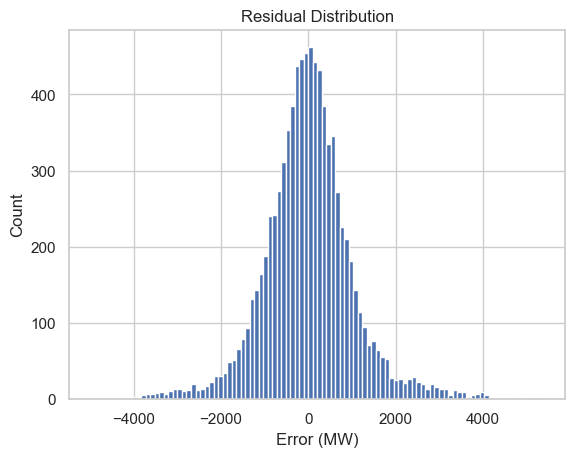

In [182]:
# plot residuals for our model
residuals = y_test - y_pred
plt.hist(residuals, bins=100)
plt.title("Residual Distribution")
plt.xlabel("Error (MW)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

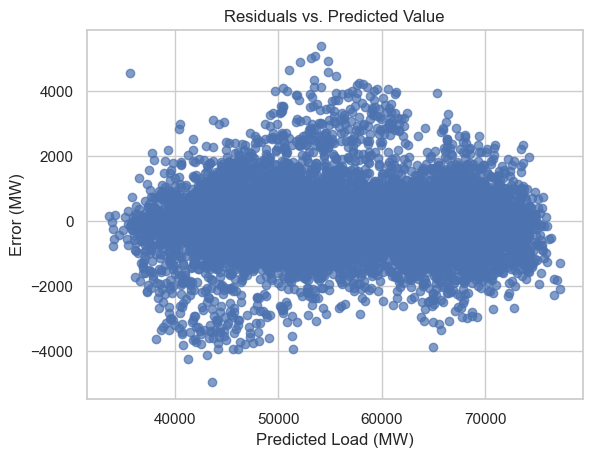

In [183]:
# check homoscedasticity
plt.scatter(y_pred, residuals, alpha=0.7)
plt.title("Residuals vs. Predicted Value")
plt.xlabel("Predicted Load (MW)")
plt.ylabel("Error (MW)")
plt.grid(True)
plt.show()

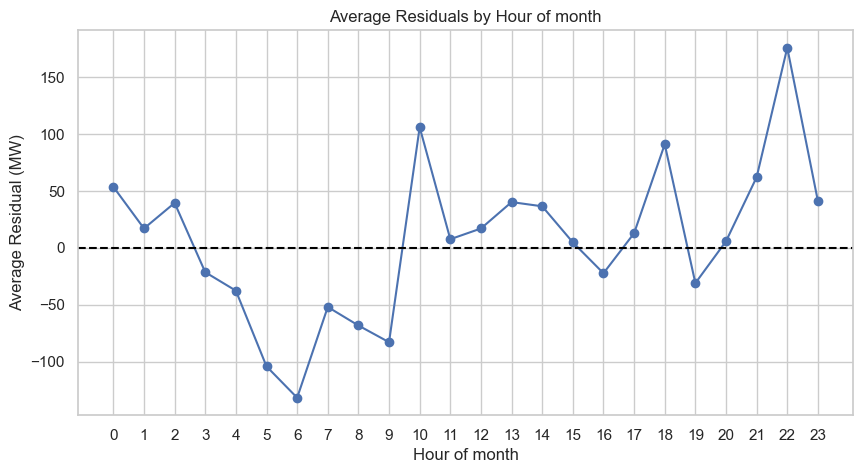

In [184]:
# check residuals over time
# residuals and hour

# hour_index = features.index("hour_sin")

res_hour = pd.DataFrame({
    "residuals": residuals,
    "hour": pd.to_datetime(time[split_idx:]).hour
}) 

hourly_mean_error = res_hour.groupby("hour")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(hourly_mean_error.index, hourly_mean_error.values, marker='o')
plt.title("Average Residuals by Hour of month")
plt.xlabel("Hour of month")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.axhline(0, color='black', linestyle='--')
plt.show()

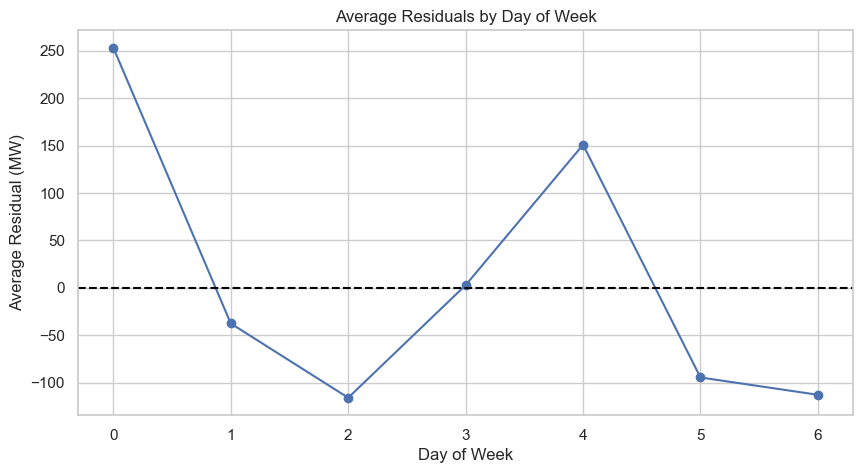

In [185]:
res_day = pd.DataFrame({
    "residuals": residuals,
    "day": pd.to_datetime(time[split_idx:]).day_of_week
}) 

daily_mean_error = res_day.groupby("day")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(daily_mean_error.index, daily_mean_error.values, marker='o')
plt.title("Average Residuals by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 7))
plt.axhline(0, color='black', linestyle='--')
plt.show()

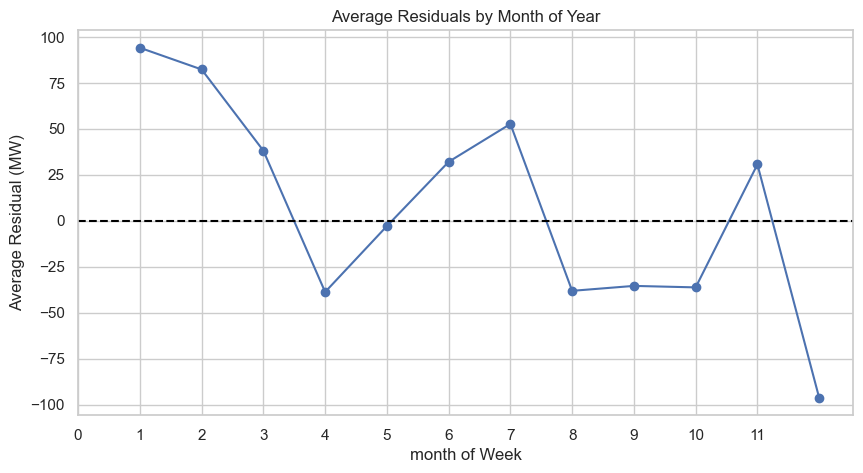

In [186]:
res_month = pd.DataFrame({
    "residuals": residuals,
    "month": pd.to_datetime(time[split_idx:]).month
}) 

monthly_mean_error = res_month.groupby("month")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_error.index, monthly_mean_error.values, marker='o')
plt.title("Average Residuals by Month of Year")
plt.xlabel("month of Week")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 12))
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [187]:
from statsmodels.stats.stattools import durbin_watson

# residuals is your array or Series of model errors
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat:.4f}")


Durbin-Watson statistic: 2.0284


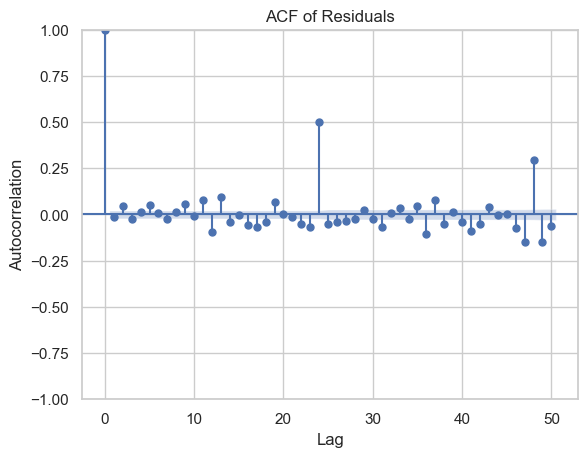

In [188]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=50)  # you can change lags as needed
plt.title("ACF of Residuals")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()


## Ridge Regression

In [189]:
tscv = TimeSeriesSplit(n_splits=5)
mae_scores, rmse_scores, mape_scores = [], [], []

alphas = [0.01, 0.1, 1]
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = make_pipeline(
        StandardScaler(),
        RidgeCV(alphas=alphas, cv=5)
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = MAE(y_test, y_pred)
    rmse = RMSE(y_test, y_pred)
    mape = MAPE(y_test, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

print(f"Avg MAE: {np.mean(mae_scores):.2f} MW")
print(f"Avg RMSE: {np.mean(rmse_scores):.2f} MW")
print(f"Avg MAPE: {np.mean(mape_scores):.2f} %")

Avg MAE: 754.94 MW
Avg RMSE: 1054.74 MW
Avg MAPE: 1.39 %


In [190]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

model = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas, cv=5)
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = MAE(y_test, y_pred)
rmse = RMSE(y_test, y_pred)
mape = MAPE(y_test, y_pred)

print(f"Linear Regression MAE:  {mae:.2f} MW")
print(f"Linear Regression RMSE: {rmse:.2f} MW")
print(f"Linear Regression MAPE: {mape:.2f} %")

Linear Regression MAE:  754.61 MW
Linear Regression RMSE: 1043.58 MW
Linear Regression MAPE: 1.40 %


In [191]:
coeff_df = pd.DataFrame({"Feature": features, "Coefficient": lr.coef_})
print(coeff_df.sort_values(by="Coefficient", key=abs, ascending=False))

             Feature  Coefficient
3             hour_4  3964.190825
4             hour_5  3705.884672
5             hour_6  3008.490603
7             hour_8  2605.917773
8             hour_9  2589.623684
15           hour_16  2368.974556
6             hour_7  2163.919685
14           hour_15  2153.485836
2             hour_3  2102.755541
9            hour_10  1595.109486
12           hour_13  1473.392886
10           hour_11  1472.202322
13           hour_14  1434.140157
11           hour_12  1400.874493
21           hour_22 -1237.431046
1             hour_2  1173.290520
20           hour_21 -1171.655330
16           hour_17  1096.107650
18           hour_19  -710.273255
0             hour_1   703.399073
19           hour_20  -475.104944
23           dow_sin   268.538175
22           hour_23  -255.495381
26         month_cos  -158.762414
17           hour_18  -116.284680
25         month_sin     5.050396
34   rad_diffuse_t-1    -3.446520
32          temp_t-1    -2.446389
24           d

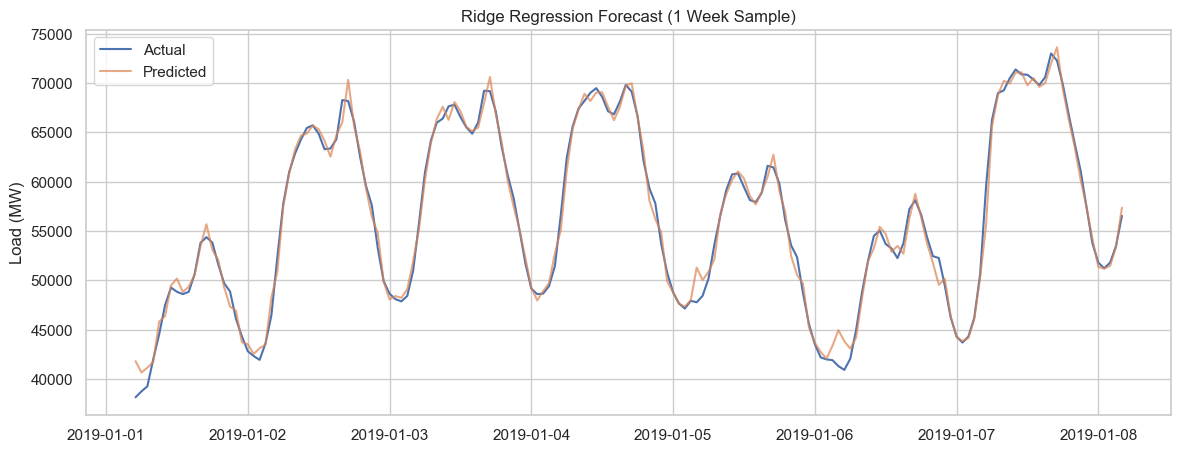

In [192]:
# Plot actual load versus predicted load for 1 week

plt.figure(figsize=(14, 5))
plt.plot(time[split_idx:split_idx+168], y_test[:168], label="Actual")
plt.plot(time[split_idx:split_idx+168], y_pred[:168], label="Predicted", alpha=0.7)
plt.title("Ridge Regression Forecast (1 Week Sample)")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## Random Forests

In [196]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer

In [198]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": [1, "sqrt", None]
}

mae_scorer = make_scorer(MAE, greater_is_better=False)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring=mae_scorer,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)
print(f"Best validation MAE: {-grid_search.best_score_:.2f} MW")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best validation MAE: 497.96 MW


In [203]:
split_idx = int(0.8 * X.shape[0])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [227]:
rf = RandomForestRegressor(
    max_depth=None,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mae = MAE(y_test, y_pred)
rmse = RMSE(y_test, y_pred)
mape = MAPE(y_test, y_pred)

print(f"Linear Regression MAE:  {mae:.2f} MW")
print(f"Linear Regression RMSE: {rmse:.2f} MW")
print(f"Linear Regression MAPE: {mape:.2f} %")

Linear Regression MAE:  444.09 MW
Linear Regression RMSE: 599.72 MW
Linear Regression MAPE: 0.81 %


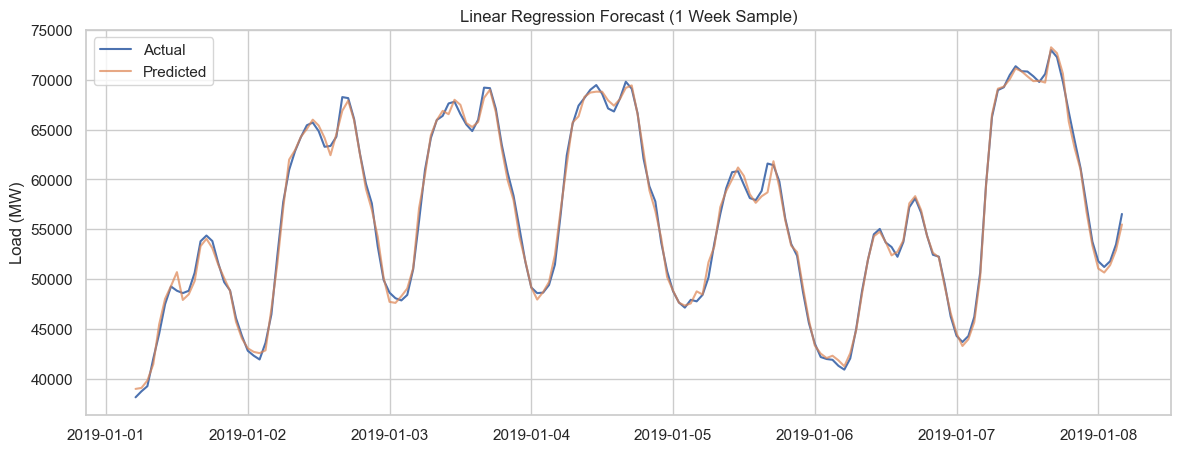

In [222]:
# Plot actual load versus predicted load for 1 week

plt.figure(figsize=(14, 5))
plt.plot(time[split_idx:split_idx+168], y_test[:168], label="Actual")
plt.plot(time[split_idx:split_idx+168], y_pred[:168], label="Predicted", alpha=0.7)
plt.title("Linear Regression Forecast (1 Week Sample)")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

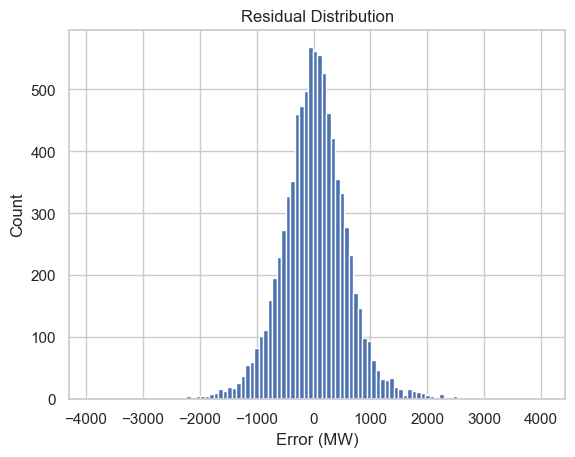

In [207]:
# plot residuals for our model
residuals = y_test - y_pred
plt.hist(residuals, bins=100)
plt.title("Residual Distribution")
plt.xlabel("Error (MW)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

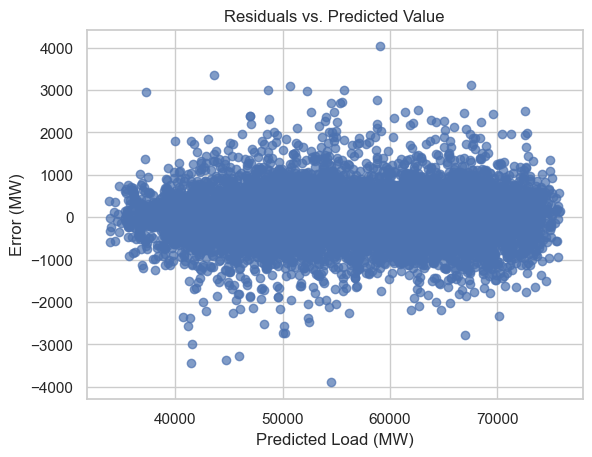

In [208]:
# check homoscedasticity
plt.scatter(y_pred, residuals, alpha=0.7)
plt.title("Residuals vs. Predicted Value")
plt.xlabel("Predicted Load (MW)")
plt.ylabel("Error (MW)")
plt.grid(True)
plt.show()

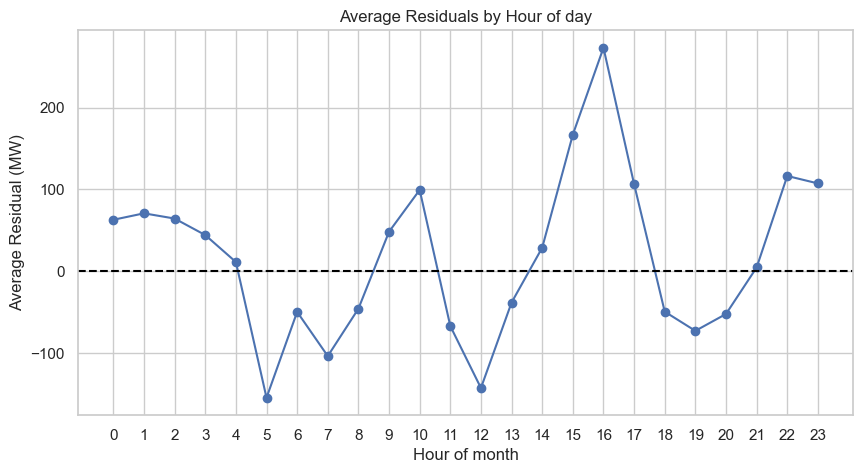

In [215]:
# check residuals over time
# residuals and hour

# hour_index = features.index("hour_sin")

res_hour = pd.DataFrame({
    "residuals": residuals,
    "hour": pd.to_datetime(time[split_idx:]).hour
}) 

hourly_mean_error = res_hour.groupby("hour")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(hourly_mean_error.index, hourly_mean_error.values, marker='o')
plt.title("Average Residuals by Hour of day")
plt.xlabel("Hour of month")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.axhline(0, color='black', linestyle='--')
plt.show()

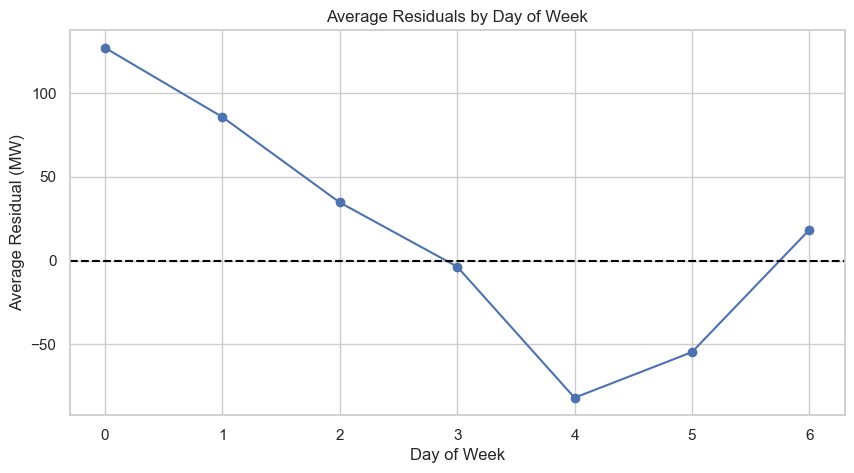

In [216]:
res_day = pd.DataFrame({
    "residuals": residuals,
    "day": pd.to_datetime(time[split_idx:]).day_of_week
}) 

daily_mean_error = res_day.groupby("day")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(daily_mean_error.index, daily_mean_error.values, marker='o')
plt.title("Average Residuals by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 7))
plt.axhline(0, color='black', linestyle='--')
plt.show()

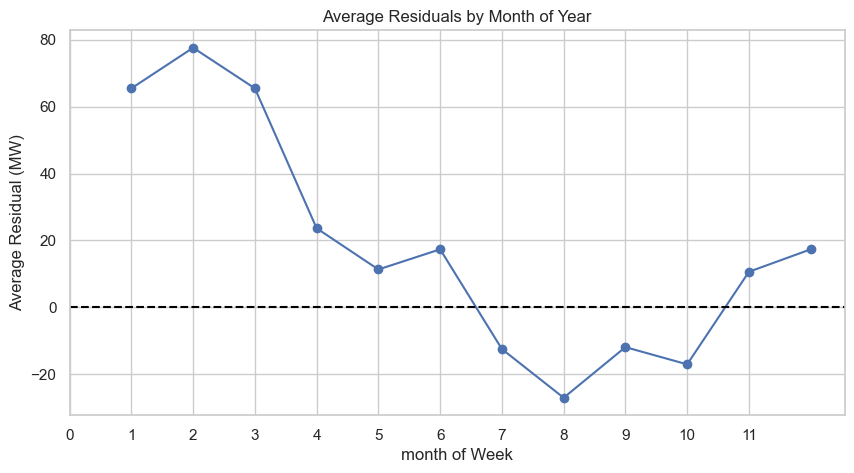

In [217]:
res_month = pd.DataFrame({
    "residuals": residuals,
    "month": pd.to_datetime(time[split_idx:]).month
}) 

monthly_mean_error = res_month.groupby("month")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_error.index, monthly_mean_error.values, marker='o')
plt.title("Average Residuals by Month of Year")
plt.xlabel("month of Week")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 12))
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [218]:
# residuals is your array or Series of model errors
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat:.4f}")


Durbin-Watson statistic: 1.7794


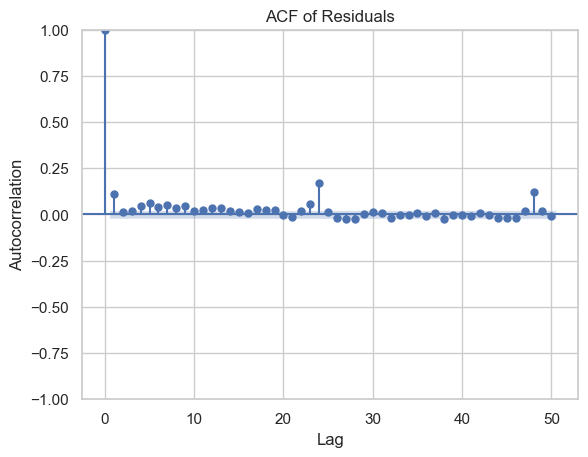

In [219]:
plot_acf(residuals, lags=50)  # you can change lags as needed
plt.title("ACF of Residuals")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

## XGBoost

In [228]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor

# Define your model
xgb = XGBRegressor(objective='reg:squarederror', n_jobs=-1)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',  # or 'neg_root_mean_squared_error'
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X, y)

# Best hyperparameters
print("Best params:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best MAE: 454.6672796518422


In [229]:
split_idx = int(0.8 * X.shape[0])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [231]:
xgb_model = XGBRegressor(
    objective="reg:squared_error",
    colsample_bytree = 1.,
    learning_rate=0.1,
    max_depth=None,
    n_estimators=500,
    subsample=0.8,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mae = MAE(y_test, y_pred)
rmse = RMSE(y_test, y_pred)
mape = MAPE(y_test, y_pred)

print(f"Linear Regression MAE:  {mae:.2f} MW")
print(f"Linear Regression RMSE: {rmse:.2f} MW")
print(f"Linear Regression MAPE: {mape:.2f} %")

Linear Regression MAE:  444.09 MW
Linear Regression RMSE: 599.72 MW
Linear Regression MAPE: 0.81 %
